<br>

# Population Densities & Missing Years



## Setting Up

Libraries

In [1]:
library(ggplot2, quietly = TRUE)

Warning message:
"package 'ggplot2' was built under R version 4.1.3"


<br>

Working directory

In [2]:
setwd(base::dirname(getwd()))
getwd()

[1] "J:/library/helminthiases/spatial"

<br>

## Functions

For extracting & interpolating population density estimates.

In [3]:
source(file = 'R/features/population/PointMapping.R')
source(file = 'R/features/population/Interpolating.R')

<br>

## Arguments

The list of experiment files

In [4]:
files <- list.files(path = file.path(getwd(), 'warehouse', 'features', 'WASH'),
                    full.names = TRUE)

<br>

Selecting a sample file

In [5]:
file <- files[6]
file

[1] "J:/library/helminthiases/spatial/warehouse/features/WASH/CD.csv"

<br>

Other arguments

In [6]:
years <- seq(from = 2000, to = 2020, by = 5)
root <- file.path(getwd(), 'data', 'population')
affix <- '_30s.tif'

<br>

Clearing

In [7]:
# storage
storage <- file.path(getwd(), 'warehouse', 'features', 'population', file)
if (dir.exists(storage)) {
  base::unlink(x = storage, recursive = TRUE)
}

<br>

## Estimates

An experiments file

In [8]:
frame <- read.csv(file = file, encoding = 'UTF-8')

In [9]:
str(frame)

'data.frame':	1864 obs. of  41 variables:
 $ iso3            : chr  "COD" "COD" "COD" "COD" ...
 $ iso2            : chr  "CD" "CD" "CD" "CD" ...
 $ admin1_id       : int  1498 1506 1498 1506 1506 1506 1506 1506 1506 1506 ...
 $ admin2_id       : int  24760 24780 24760 24779 24780 24779 24779 24779 24779 24777 ...
 $ iu_id           : int  13954 14228 13936 14219 14225 14220 14286 14221 14258 14276 ...
 $ site_id         : int  11460 50809 11327 50726 50772 50730 52022 50735 51550 51875 ...
 $ longitude       : num  20.4 25.2 21 30.5 25.3 ...
 $ latitude        : num  2.42 1.09 2.78 3.05 1.57 ...
 $ georeliability  : int  3 3 3 3 3 3 3 3 3 3 ...
 $ location_type   : chr  "" "" "" "" ...
 $ survey_type     : chr  "" "" "" "" ...
 $ year            : int  2015 2013 2015 2013 2013 2013 2013 2013 2013 2013 ...
 $ age_start       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ age_end         : int  NA NA NA NA NA NA NA NA NA NA ...
 $ hk_examined     : int  50 50 50 30 50 50 50 50 50 50 ...
 $

<br>

### Extracting Densities


Next, extracting population density estimates, per map year, from the 

* [`geodata`](https://github.com/rspatial/geodata#data): The `geodata` population density maps are [accessible directly](https://geodata.ucdavis.edu/geodata/pop/), and are the Gridded Population of the World maps.
* [Gridded Populations of the World](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4/documentation)

Map year estimates only exist for the years $2000,2005, 2010, 2015, 2020$.  Hence, and per observation, the population density estimates per map year; extracted from the maps via the observation's co&ouml;rdinates.

In [10]:
estimates <- mapply(FUN = PointMapping, year = years, MoreArgs = list(root = root, affix = affix, frame = frame))
estimates <- dplyr::bind_rows(estimates)
row.names(estimates) <- NULL

head(estimates)

,estimate,longitude,latitude,id,year
,<dbl>,<dbl>,<dbl>,<int>,<int>
1,23.35333,20.39833,2.415278,0,2000
2,6.30000,25.24098,1.091740,1,2000
3,23.40000,21.04194,2.784722,2,2000
4,69.00000,30.54483,3.053970,3,2000
5,6.30000,25.31193,1.565600,4,2000
6,69.00000,30.82867,2.861280,5,2000


<br>

### Unavailable Densities

Missing values can't be interpolated.

In [11]:
unavailable <- estimates[is.na(estimates$estimate), ]
indices <- unique(unavailable$id)
indices

[1]   22   23  131  184  292  294  325  326  329  338  339  341  348  428  708
[16]  722  736  856  892  999 1014 1043 1052 1067 1118 1134 1135 1171 1181 1232
[31] 1298 1310 1329 1342 1399 1417 1581 1582 1584 1585 1586 1589 1590 1591 1593
[46] 1594 1606 1620 1674 1680 1689 1694 1697 1764 1765 1766 1788 1799 1808

In [12]:
estimates <- estimates[!(estimates$id %in% indices), ]

<br>

### Interpolating


In <estimates> each observation of <frame> is associated with population density estimates for the years {2000, 2005, 2010, 2015, 2020}.  Remember, the observation
code is field <id>.  The function Interpolating(.) estimates the population densities of the intervening years.

In [13]:
interpolations <- mapply(FUN = Interpolating, id = unique(estimates$id),
                         MoreArgs = list(estimates = estimates, years = years))
interpolations <- dplyr::bind_rows(interpolations)
row.names(interpolations) <- NULL
interpolations <- dplyr::rename(interpolations, 'p_density' = 'estimate')

In [14]:
str(interpolations)

'data.frame':	37905 obs. of  3 variables:
 $ year     : int  2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 ...
 $ p_density: num  23.4 24.3 25.2 26.1 27.1 ...
 $ id       : int  0 0 0 0 0 0 0 0 0 0 ...


<br>

### Joining/Merging

Finally, appending a population density field to <frame>

In [15]:
extended <- dplyr::left_join(x = frame, y = interpolations, by = c('id', 'year'))

<br>

Unavailable

In [16]:
cat(glue::glue('Population density estimates indeterminable for {sum(is.na(extended$p_density))} observations.'))

Population density estimates indeterminable for 79 observations.

<br>

## Illustrating

### Interpolated Densities Example

In [17]:
sample <- interpolations[interpolations$id == 3, ]
sample$segment <- 'with interpolations'

In [18]:
original <- sample[sample$year %in% years, ]
original$segment <- 'estimate'

In [19]:
series <- base::rbind(original, sample)
series

,year,p_density,id,segment
,<int>,<dbl>,<int>,<chr>
64,2000,69.00000,3,estimate
69,2005,84.20000,3,estimate
74,2010,102.80000,3,estimate
79,2015,125.50000,3,estimate
84,2020,153.20000,3,estimate
641,2000,69.00000,3,with interpolations
65,2001,71.90423,3,with interpolations
66,2002,74.84240,3,with interpolations
67,2003,77.84845,3,with interpolations


<br>

### The Graph



Note, within `ggplot2::theme(.)` below - the arguments of `ggplot2::margin(.)` are

```shell
ggplot2::margin(t = 0, r = 0, b = 0, l = 0, unit = 'pt')
```

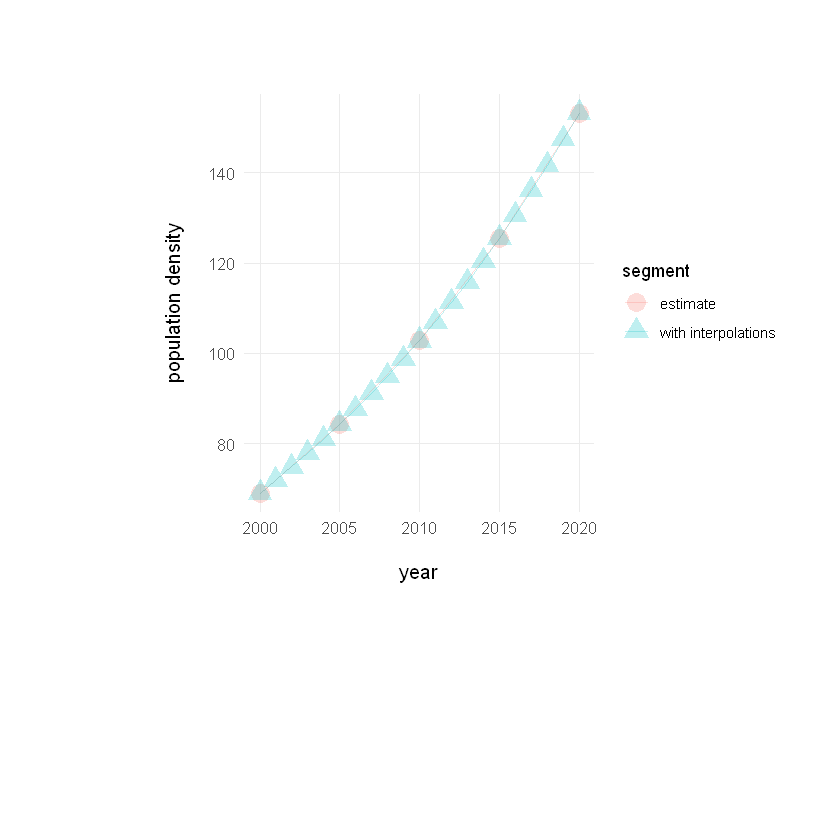

In [20]:
ggplot(data = series, mapping = aes(x = year, y = p_density, colour = segment, shape = segment)) +
    geom_point(alpha = 0.25, size = 5) + 
    geom_line(alpha = 0.25) + 
    theme_minimal() + 
    theme(panel.grid.minor = element_blank(),
          panel.grid.major = element_line(size = 0.05),
          plot.margin = margin(2, 1, 5, 3, 'cm'),
          axis.title.x = element_text(size = 12), axis.title.y = element_text(size = 12),
          axis.text.x = element_text(size = 10), axis.text.y = element_text(size = 10)) +
    xlab(label = '\nyear\n') + 
    ylab(label = '\npopulation density\n')